### Amostragem ideal de um sinal analógico e reconstrução utilizando o filtro passa baixa ideal

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

### ***Construção do sinal***

1) Gerar o sinal 𝑥(𝑡)=cos⁡(2𝜋100𝑡) no intervalo de -5 a 5 segundos.

Frequência de amostragem ($f_s$): 100 Hz
Frequência com maior contribuinte: 10.0 Hz

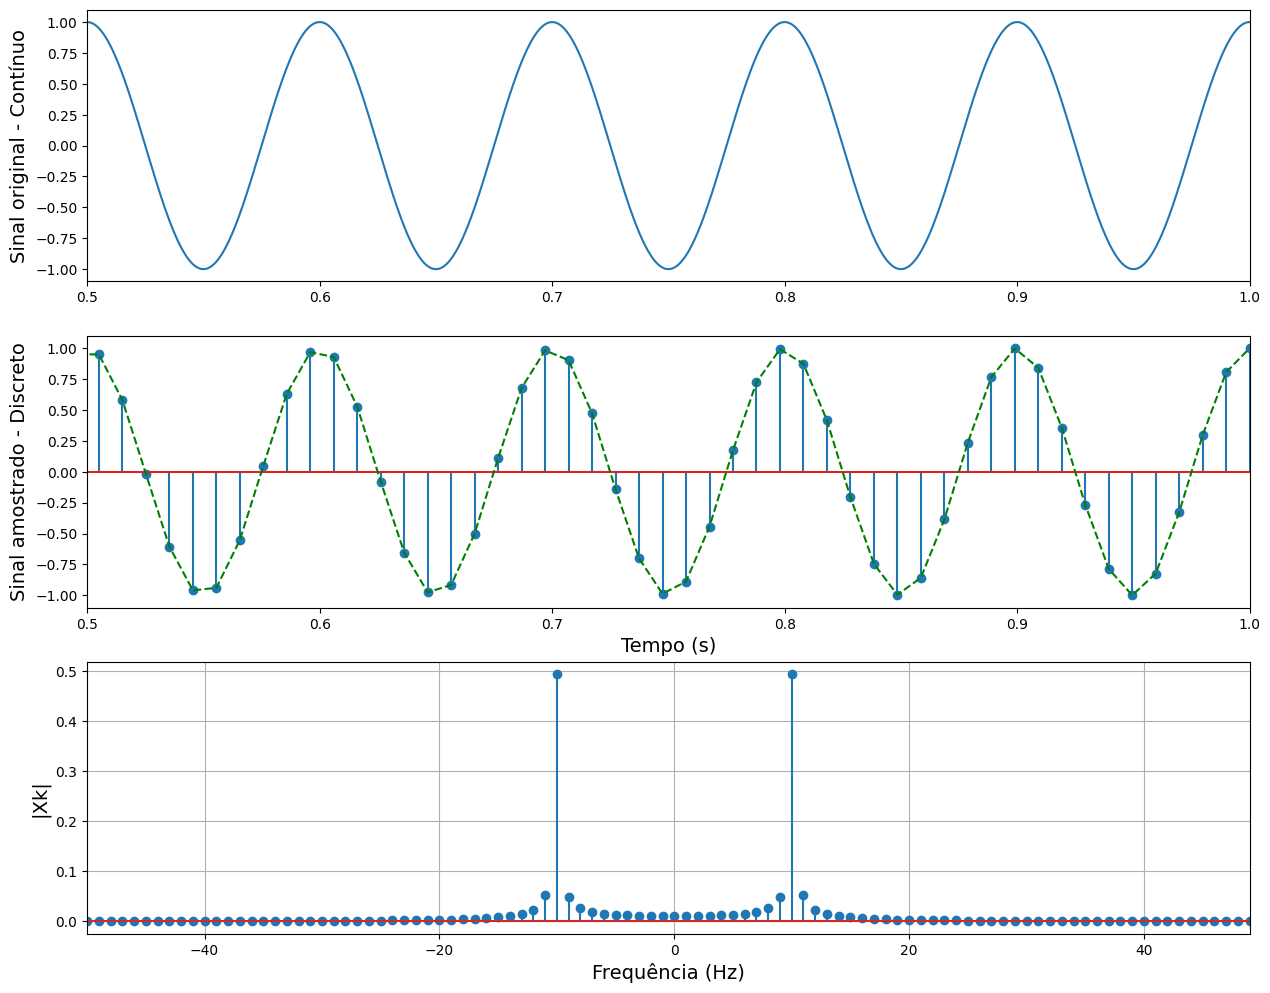

In [167]:
#-------PARAMETROS--INICIAIS--------------------------
# Informacoes do tom e frequencia de amostragem
ti = 0
tf = 1
fa = 10
fs = 100
ciclosMostrar = 5
fs_analogico = 1e4

amostras = True 
interpolado = True
#------------------------------------------------------

def spectrum(xa, T0):
  fs = int(len(xa)/T0)
  Xk = np.fft.fft(xa)
  hs = np.abs(Xk)
  hs *= 1/len(xa)
  freqs = np.fft.fftfreq(len(xa), 1./fs)
  return freqs, hs

def plot_spectrum(xr,ttot, limFreq = False):
  freqs, hs = spectrum(xr, ttot)
  fsRec = abs(round(freqs[np.argmax(hs)],2))
  print(f"""Frequência com maior contribuinte: {fsRec} Hz""", end='')

  if limFreq:
    freqs_fs = len(freqs)/(max(freqs)-min(freqs))
    freqs = np.fft.fftshift(freqs)
    hs = np.fft.fftshift(hs)
    Nmin = int(np.floor((-limFreq - min(freqs))*freqs_fs))
    Nmax = int(np.ceil((limFreq - min(freqs))*freqs_fs))
    plt.stem(freqs[Nmin:Nmax], hs[Nmin:Nmax], '-o')
    plt.xlim([-limFreq, limFreq])
  else:
    plt.stem(freqs, hs, '-o')
    plt.xlim([min(freqs), max(freqs)])
  plt.xlabel("Frequência (Hz)", fontsize=14)
  plt.ylabel("|Xk|", fontsize=14)
  plt.grid('on')
  return fsRec
#------------------------------------------------------

ttot = tf -ti
t = np.linspace(ti,tf,int(ttot*fs_analogico)) # fs=1e6 para simular o analogico
xt = np.cos(2*np.pi*fa*t)

tsampling = np.linspace(ti,tf,int(ttot*fs))
xtsampling = np.cos(2*np.pi*fa*tsampling)

print(f"""Frequência de amostragem ($f_s$): {fs} Hz""")

fig = plt.figure(figsize=(15,12)) # comprimento (x) e altura (y)
plt.subplot(311)
plt.plot(t, xt)
plt.ylabel("Sinal original - Contínuo", fontsize=14)
plt.xlim([tf-ciclosMostrar/fa, tf])

plt.subplot(312)
if amostras:
  plt.stem(tsampling, xtsampling)
if interpolado:
  plt.plot(tsampling, xtsampling, color='green', linestyle='dashed')
plt.ylabel("Sinal amostrado - Discreto", fontsize=14)
plt.xlabel("Tempo (s)", fontsize=14)
plt.xlim([tf-ciclosMostrar/fa, tf])

plt.subplot(313)
plot_spectrum(xtsampling, ttot)

plt.savefig('sinal.png', format='png')
plt.show()

### ***Reconstrução do sinal***

2) Após fazer a amostragem do sinal seguindo a observação (\*), reconstruir o sinal em um intervalo de tempo To, compreendido entre 0 e 1, com base no teorema da dimensionalidade e a resposta impulsiva do filtro passa baixa ideal (versão truncada). Qual será a frequência do sinal recuperado?
(*)O Teorema da Dimensionalidade fornece o número mínimo de amostras para reconstrução do sinal, ou seja, N amostras em um intervalo de tempo To (Couch). Determine a frequência de amostragem, considerando que você a utilizará para reconstrução do sinal no intervalo To, o seguinte número de amostras V:

a) V = (N + 1) amostras (pois estamos reconstruindo um tom);


b) V igual a 3N;

Pelo teorema da dimensionalidade, serão necessárias $N$ amostras, sendo

$$N = 2\ B\ T_0$$
$$N = 2*100*1 = 200$$

Sabendo que serão utilizadas V amostras, em que V depende de N, então tem-se a frequência de amostragem:

$$V = fs\ T_0$$
$$fs = V/T_0 \text{, em amostras/segundo}$$ 

In [168]:
def plot_resultados(t,xt,tf,ciclosMostrar,fa,xr,V,fs,tsampling,xtsampling):
    plt.figure(figsize=(20,8))

    plt.subplot(411)
    plt.plot(t, xt)
    plt.ylabel("Sinal original", fontsize=14)
    plt.xlim([tf-ciclosMostrar/fa,tf])

    plt.subplot(412)
    plt.plot(t,xr)
    plt.scatter(tsampling, xtsampling, color='orange')
    plt.ylabel("Sinal recuperado", fontsize=14)
    plt.xlim([tf-ciclosMostrar/fa,tf])

    plt.subplot(413)
    plt.plot(t,np.abs(xr-xt), "red")
    plt.ylabel("Erro absoluto", fontsize=14)
    plt.xlim([tf-ciclosMostrar/fa,tf])

    print(f"""\\vspace{{12pt}}
\\noindent Resultado obtido:
""")
        
    plt.subplot(414)
    fsRec = plot_spectrum(xr,ttot, 2*fa)
    
    emq = sum((xr-xt)**2)/len(t)
    print(f"""\\\\
\indent Frequência de amostragem ($f_s$): {fs} Hz\\\\
\indent Erro médio quadrático (EMQ): {'{:.2e}'.format(emq)}\\\\

V = {V} amostras\\\\
\indent No sinal "analógico": {len(t)} amostras\\\\
\\vspace{{12pt}}
""")
    return V, fs, fsRec, emq
    
class Info():
    fa = 10
    V = 0
    fs = 0
    fsRec = 0
    emq = 0
    condicaoV = 0
    filtro = 0
    ttot = 0
    ti = 0
    tf = 0
    t, xt, xr,tsampling,xtsampling = []
    ciclosMostrar = 0
    
    def __init__(self, fa=10):
        self.fa = fa

In [169]:
N = int(np.ceil(2*fa*ttot))

#--------------------------------------------------------------------
def hIdeal(t, fs):
    return np.sinc(fs*t) 

def h0(t, Ts):
    return np.int8(0<=t and t<=Ts) # return ::0 ou 1::

def h0_array(tarray, Ts):
    return np.array([h0(t,Ts) for t in tarray])

def h1(t, Ts):
    return (0 if (abs(t)>Ts) else ((t/Ts+1) if (-Ts<t and t<0) else (-t/Ts+1))) # return ::float::

def h1_array(tarray, Ts):
    return np.array([h1(t,Ts) for t in tarray])
    
def h(t, Ts, filtro=0):
    if filtro==-1:
        return hIdeal(t,1/Ts) 
    if filtro==0:
        return h0_array(t,Ts)
    elif filtro==1:
        return h1_array(t,Ts)

def Vdef(Vcase):
    return 6*N if Vcase else (N+1)

def caso(condicaoV, filtro, ttot, ti, tf, fa, t):
    V = Vdef(condicaoV)
    fs = V/ttot
    Ts = 1/fs
    tsampling = np.linspace(ti,tf,int(ttot*fs))
    xtsampling = np.cos(2*np.pi*fa*tsampling)
    return V, fs, tsampling, xtsampling, recuperarSinal(filtro, t, xtsampling, Ts, V)
    

#--------------------------------------------------------------------

def recuperarSinal(filtro, t, xtsampling, Ts, V):
    xr = np.zeros(len(t))
    for i in tqdm(range(0,V)):
        xr = xr + xtsampling[i]*h(t-i*Ts, Ts, filtro)
    return xr

#--------------------------------------------------------------------

In [170]:
# time = np.linspace(-5, 5, 10000)
# ts = 2
# plt.figure(figsize=(10,4))
# for f in [hIdeal, h0_array, h1_array]:
#     plt.plot(time, f(time, ts))
# plt.legend(["Ideal", "Ordem 0", "Ordem 1"])
# plt.xlim([-5,5])
# plt.grid()
# plt.savefig('interpoladores.png', format='png')
# plt.show()

In [ ]:
idealN1 = Info()
ideal6N = Info()
ordem0N1 = Info()
ordem06N = Info()
ordem1N1 = Info()
ordem16N = Info()

# Interpolador ideal

print(f"{bcolors.BOLD}------------- Interpolador Ideal ------------------------------------\n")
V, fs, tsampling, xtsampling, xr = caso(0,-1, ttot, ti, tf, fa, t)
idealN1.V, fs, fsRec, emq = plot_resultados(t,xt,tf,ciclosMostrar,fa,xr,V,fs,tsampling,xtsampling)
plt.savefig('ideal_N1.png', format='png')
plt.show()

# V, fs, tsampling, xtsampling, xr = caso(1,-1, ttot, ti, tf, fa, t)
# plot_resultados(t,xt,tf,ciclosMostrar,fa,xr,V,fs,tsampling,xtsampling)
# plt.savefig('ideal_6N.png', format='png')
# plt.show()

# # Interpolador de ordem 0

# print(f"{bcolors.BOLD}------------- Interpolador de ordem 0 -------------------------------\n")
# V, fs, tsampling, xtsampling, xr = caso(0,0, ttot, ti, tf, fa, t)
# plot_resultados(t,xt,tf,ciclosMostrar,fa,xr,V,fs,tsampling,xtsampling)
# plt.savefig('ordem0_N1.png', format='png')
# plt.show()

# V, fs, tsampling, xtsampling, xr = caso(1,0, ttot, ti, tf, fa, t)
# plot_resultados(t,xt,tf,ciclosMostrar,fa,xr,V,fs,tsampling,xtsampling)
# plt.savefig('ordem0_6N.png', format='png')
# plt.show()

# # Interpolador de ordem 1

# print(f"{bcolors.BOLD}------------- Interpolador de ordem 1 -------------------------------\n")
# V, fs, tsampling, xtsampling, xr = caso(0,1, ttot, ti, tf, fa, t)
# plot_resultados(t,xt,tf,ciclosMostrar,fa,xr,V,fs,tsampling,xtsampling)
# plt.savefig('ordem1_N1.png', format='png')
# plt.show()

# V, fs, tsampling, xtsampling, xr = caso(1,1, ttot, ti, tf, fa, t)
# plot_resultados(t,xt,tf,ciclosMostrar,fa,xr,V,fs,tsampling,xtsampling)
# plt.savefig('ordem1_6N.png', format='png')
# plt.show()

In [174]:
print(f"""
\\begin{{table}}[]
\\begin{{tabular}}{{@{{}}ccccc@{{}}}}
\\toprule
\\textbf{{Frequência do sinal (Hz)}} & \\textbf{{V (amostras)}} & \\textbf{{Frequência de amostragem (Hz)}} & \\textbf{{Frequência do sinal recuperado (Hz)}} & \\textbf{{EMQ}} \\\\ \\midrule
{fa} & {V}  &  &  &  \\\\
{fa} & {V}  &  &  &  \\\\
{fa} & {V}  &  &  &  \\\\ \\bottomrule
\\end{{tabular}}
\\end{{table}}
""")


\begin{table}[]
\begin{tabular}{@{}ccccc@{}}
\toprule
\textbf{Frequência do sinal (Hz)} & \textbf{V (amostras)} & \textbf{Frequência de amostragem (Hz)} & \textbf{Frequência do sinal recuperado (Hz)} & \textbf{EMQ} \\ \midrule
 &  &  &  &  \
 &  &  &  &  \
 &  &  &  &  \\ \bottomrule
\end{tabular}
\end{table}

